# **Columbia Instructor Ratings (Final Report)**

#### A Project for APMA 4990: Introduction to Data Science in Industry
#### By: Pranjal Bajaj, Nicholas Wong, and Weida Xu

## Contents
[1. About this Project](#1) <br>
[2. Getting the Data](#2) <br>
[3. Preparing the Data](#3) <br>
[4. Preprocessing the Data for Analysis](#4) <br>
[5. Main Model: Logistic Regression with TF-IDF Input Vectorization](#5) <br>
[6. Other Models Explored](#6) <br>
[7. Recommendation Engine (Abandoned Feature)](#7) <br>
[8. Flask Webapp and SQLite](#8) <br>
[9. Drawbacks of pythonanywhere and Future Features](#9)

## 1. About this Project <a name="1"></a>

The goal of this project is to provide students with a convenient way to assess and compare professors/lecturers/instructors at Columbia University using data from text reviews from the Columbia Underground Listing of Professor Ability, aka [CULPA](culpa.info). CULPA is a website where students at Columbia University can leave anonymous reviews for their professors, and as of 2018 claims to host over 26900 reviews, some of which date as far back as 1999. Although Columbia's registrar has in recent years started releasing official instructor evaluations on their own [website](https://vergil.registrar.columbia.edu/), CULPA still remains as a vital source of candid information about professors and courses which cannot be found in the official evaluations.

The primary aim of this project is to assign a rating for each professor based on a sentiment analysis of the professor's CULPA reviews. Inspired by the [RottenTomatoes](https://rottentomatoes.com/) rating system, each review is given a score of either 'positive' or 'not positive', and these scores are aggregated to produce a final score which reveals the percentage of reviews which are positive. To prevent unfair or biased reviews from unduly affecting the final score, the sentiment scores are weighted by the ratio of people who 'agree' with the review on CULPA. For reviews without any 'agree' or 'disagree' scores, the weight will be set to the mean of all other reviews for the same professor.

The secondary aim of this project is to provide a summary of the reviews provided so that students will be able to get the gist of each review in a single glance. This is done using the gensim package which is an implementation of the modified TextRank algorithm by *Federico Barrios, Federico L´opez, Luis Argerich, Rosita Wachenchauzer (2016)*.

There was initially a tertiary aim of providing recommendations of professors and courses based on the similarities between the reviews for professors, but this idea was scrapped due to poor performance of the recommendation algorithm given the limitations of the available data (this will be discussed further below).

## **2. Getting the Data** <a name="2"></a>

The first step for our project was to obtain the necessary data on which to conduct the sentiment analysis. Although CULPA's front page claims to have an [API](http://api.culpa.info/), it appears that the API is no longer supported as of 2018. As such we had to manually scrape all the necessary data using the BeautifulSoup package in Python. 

There were 5 hurdles in trying to scrape the review data from CULPA.

The first was that there did not seem to be any consistent pattern in the URLs for the reviews, e.g. culpa.info/reviews/professor-course-review#. Instead, the URLs for the reviews used random strings of (non-consecutive) numbers of varying lengths, which forced us to use a brute force method of trying every number from 1 to 100,000.

Second, the website seemed overly sensitive to potential DDoS attacks, and would deny requests if too many were being made. This was especially frustrating for us as we had to go through the 100,000 requests using for-loops and even a single dropped request would result in the loop being aborted. While the problem was ameliorated by running multiple for-loops in parallel, the connection errors persisted and we were forced to make requests in batches as small as 1,000 at a time.

Third, the HTML code/content for the website was not fixed over time, which caused problems for us during the scraping process since some of our conditionals were hard-coded (e.g. using the number of characters to determine if we have been redirected to the home page). CULPA might have been undergoing some maintenance during the period we were trying to scrape reviews, since some of our scraping code which worked perfectly fine would suddenly fail a week later. 

Fourth, a lot of professors had multiple departmental affiliations and taught multiple courses, which complicated the scraping process since the we could no longer just grab the '.text' within the html tags but had to use some regex workarounds to obtain the other departments and courses. A further problem was that having multiple entries being appended to the list used to hold the information would disrupt the order in which the entries were made. We got around this issue by storing multiple courses/departments as tuples to be unpacked later.

Last, there were a lot of 'phantom reviews' and 'phantom professors', i.e. reviews that could be obtained via a direct URL request but were nowhere to be found on the CULPA website itself. We suspect that these reviews may have been pending withheld or moderated by the administrators, but since there were too many reviews to check against the website we decided to simply use our collected data as is. There were also some discrepancies in the figures provided by CULPA. While their front page claims that "12000+ professors" have been reviewed on the site, we could only find a little under 4300 professors who have been reviewed. Furthermore, while CULPA claims to have "26900+ reviews", we were only successful in obtaining around 25900 reviews -- a full thousand reviews short.

#### The code below was used to scrape review data from CULPA

In [ ]:
df = pd.DataFrame(columns=['review_id', 'review_date' ,'review_text', 'agree_score', 'disagree_score',
                             'funny_score', 'professor_id', 'professor_name', 'course_id', 'course_name'])
for i in tqdm(range(0, 100000)):
    url = 'http://culpa.info/reviews/{}'.format(i)
    r = urlopen(url).read() 
    soup = BeautifulSoup(r, "lxml") 
    # if review doesn't exist, it redirects to home page which has a length of exactly 14935
    if len(soup.text) == 14935:
        continue
    
    professor = soup.find(href=re.compile('(professor)'))
    if professor == None:
        professor_id = None
        professor_name = None
    else:
        professor_id = professor['href'][12:]
        professor_name = professor.text
    
    courses = soup.find_all(href=re.compile('(courses)'))
    if courses == None:
        course_id = None
        course_name = None
    else:
        if str(courses[-1]).find('class') == -1:
            course_id = None
            course_name = None
        else:
            course_id = courses[-1]['href'][9:]
            course_name = courses[-1].text

    review_id = soup.find(href=re.compile('(reviews)'))['href'][9:]
    review_text = soup.find(class_='review_content').text
    review_date = pd.Timestamp(soup.find(class_='date').text.strip())
    agree_score = re.findall('\d+', soup.find(class_='agree')['value'])[0]
    disagree_score = re.findall('\d+', soup.find(class_='disagree')['value'])[0]
    funny_score = re.findall('\d+', soup.find(class_='funny')['value'])[0]

    to_append = pd.DataFrame(data=[review_id, review_date, review_text, agree_score, 
                                   disagree_score, funny_score, professor_id, professor_name,
                                   course_id, course_name],
                            index=['review_id', 'review_date' ,'review_text', 'agree_score', 
                                   'disagree_score', 'funny_score', 'professor_id', 
                                   'professor_name', 'course_id', 'course_name']).T
    
    df = pd.concat([df, to_append], ignore_index=True)

#### The code below was used to scrape professor data from CULPA

In [ ]:
prof_list = list(set(df.professor_name))
prof_list.pop(1) # To get rid of an inexplicable 'nan' in the set
prof_list = sorted(prof_list)

prof_id = []
for prof in prof_list:
    prof_id.append(df.professor_id[df.professor_name == prof].iloc[0])

prof_id = list(map(int, prof_id))


# Get professor department 

prof_dept = []
nugget = []
prof_courseinfo = []

for i in tqdm(prof_id):
    
    url = 'http://culpa.info/professors/{}'.format(i)
    r = urlopen(url).read() 
    soup = BeautifulSoup(r, "lxml")  
    if len(soup.text) == 14935:
        prof_dept.append('None')
        nugget.append('None')
        prof_courseinfo.append('None')
        continue
        
    # Get course information
    
    courseinfo = soup.find_all(class_='professor')[0].find_all('p')[2].find_all('a')

    if courseinfo == None:
            prof_courseinfo.append('None')

    elif len(courseinfo) == 1:
        info = (courseinfo[0].text, [i.replace('/', '') for i in re.findall('\/\d+', str(courseinfo))].pop())
        prof_courseinfo.append(info)

    else:
        courses = []
        ids = [i.replace('/', '') for i in re.findall('\/\d+', str(courseinfo))]
        for course in courseinfo:
            courses.append(course.text)
        info = list(zip(courses, ids))
        prof_courseinfo.append(info)
    
    # Get department information
    dept = soup.find_all(class_='professor')[0].find_all('p')[1].find_all('a')
    
    if dept == None:
            prof_dept.append('None')
            
    elif len(dept) == 1:
        dept_info = (dept[0].text, [i.replace('/', '') for i in re.findall('\/\d+', str(dept))].pop())
        prof_dept.append(dept_info)
    
    # Get nuggets
    else:
        depts = []
        ids = [i.replace('/', '') for i in re.findall('\/\d+', str(dept))]
        for d in dept:
            depts.append(d.text)
        dept_info = list(zip(depts, ids))
        prof_dept.append(dept_info)
              
    if soup.find(class_='nugget') is None:
        nugget.append('None')
    elif str(soup.find(class_='nugget'))[10:14] == 'Gold':
        nugget.append('Gold')
    else:
        nugget.append('Silver')

In [ ]:
# Sanity check
assert len(prof_dept) == len(nugget) == len(prof_list) == len(prof_id) == len(prof_courseinfo)

prof_data = pd.DataFrame(
    {'Name': prof_list,
     'ID': prof_id,
     'Dept': prof_dept,
     'Nugget': nugget,
     'Courses': prof_courseinfo
    })

prof_data = prof_data[['Name', 'ID', 'Dept', 'Courses', 'Nugget']]

## 3. Preparing the Data <a name="3"></a>

Because the reviews we obtained came as raw text reviews, we had to manually label a subset of the data for validation purposes to conduct any kind of supervised learning. Because it was not feasible to label all 25900 reviews by hand, we chose the subset of all reviews posted since Jan 1, 2015, for a total of 2178 labeled reviews. While this admittedly arbitrary cutoff raised some concerns about the labeled and unlabeled data coming from possibly different distributions since they are temporally separated, we decided to label this sample instead of a random sample because at the time we had not decided on whether we were going to apply our learning algorithm to all the reviews or just the most recent ones. Furthermore, a visual inspection also led us to believe that the distribution of words from older reviews did not actually differ much (or at all) from the distribution of words used in more recent reviews.

To label the data, we used the *RottenTomatoes* rubric of giving a positive label as long as the review had an overall positive sentiment (from mildly positive to wildly positive), and a non-positive label for anything else. The labeling was done manually in Microsoft Excel, and each review was skimmed and assigned a score. While there is always a possibility that our manual labeling might not actually reflect the ground truth, we reasoned that any human error would probably approximate the *Bayes error rate*, which is the theoretical lower bound for classification algorithms.

Furthermore, we also tried manually assigning ratings for the workload of each course, but this was found to be a much harder exercise than mere sentiment review since a lot in the review data merely described the workload in non-normative terms which would require too much value judgment on our part to render a rating. (e.g. Is 10 hours a week high or low? Does this vary by department?) In the end we abandoned the workload labels after labeling about 2000 samples, and did not use them for further analysis.

## 4. Preprocessing the Data for Analysis <a name="4"></a>

In [27]:
# Basic Libraries 
import pandas as pd
import numpy as np

# Web Scraping Tools 
from bs4 import BeautifulSoup 
from urllib.request import urlopen
import re

# NLTK
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download() # only need to do this once

## Preprocessing for modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MaxAbsScaler

# Modelling 

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Doc2Vec

## Unsupervised
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

## Plotting
import matplotlib.pyplot as plt
from preamble import *

## Genism
import gensim
from gensim import corpora

# progress tracker 
from tqdm import tqdm

import warnings

In [2]:
# Import the scraped review data
df = pd.read_csv('data/Final Dataframe/dataframe_final.csv')

In [5]:
# Extract the labeled data
X = df.review_text[23391:]
y = df.review_label[23391:]

In [7]:
# Create function to binarize the labels
## Missing values were converted to 0 since they were usually left blank during the labeling process because of ambivalence.
## Ambivalent reviews would get a score of 0 according to the RottenTomatoes scale.

def binarizer(y):
    
    if y == 2:
        return 1
    else:
        return 0

In [8]:
# Binarize the labels
y = y.map(binarizer)

In [47]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 45)

## 5. Main Model: Logistic Regression with TF-IDF Input Vectorization <a name="5"></a>

Our main model for sentiment analysis is the logistic regression with a tf-idf vectorization. Logistic regression is a basic classification model that predicts classes based on a sigmoid transformation of a linear combination of input features. tf-idf vectorization is a method of transforming the review texts into a matrix of tf-idf features, which is basically a frequency matrix weighted by inverse document frequency. The tf-idf value of words increase proportionally with frequency within a document but decreases with overall frequency in the corpus, which accounts for the fact that some words simply appear frequently regardless of context (e.g. 'the'). According to wikipedia, tf-idf is the most popular weighting scheme for text-based recommendation engines.

In [109]:
# Fit training data to tf-idf vectorizer
tfidf = TfidfVectorizer(stop_words='english', min_df = 0.005).fit(X_train) #, ngram_range = (1, 1), min_df = 0.005

# Transform data
X_train_1 = tfidf.transform(X_train)

# feature names
#features_tfidf = tfidf.get_feature_names()

In [11]:
# Define logit model
lr = LogisticRegression(class_weight = 'balanced')

In [111]:
# Train initial run
lr.fit(X_train_1, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [112]:
# Print metrics
print('Model Accuracy: ' , lr.score(X_train_1, y_train))
pred = lr.predict(X_train_1)
print('Model AUC Score: ' , roc_auc_score(y_train, pred))

Model Accuracy:  0.9193877551020408
Model AUC Score:  0.9284480631630889


The model seems to be performing well on the training data. It has a 0.919 training accuracy and a 0.928 AUC ROC score. We will now run the model on the testing data.

In [18]:
X_test_1 = tfidf.transform(X_test)
print('Model Accuracy: ' , lr.score(X_test_1, y_test))
pred = lr.predict(X_test_1)
print('Model AUC Score: ', roc_auc_score(y_test, pred))

Model Accuracy:  0.8532110091743119
Model AUC Score:  0.8579931084890885


The testing metrics also seem to be good, with an accuracy of 0.853 and a 0.857 AUC ROC score. We will cross-validate the model below to ensure that it is robust.

In [12]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [117]:
scores = cross_val_score(lr, X_train_1, y_train, scoring='roc_auc', cv = cv ) 
print("Mean Cross-Validation AUC Score: {:.2f}".format(np.mean(scores))) 

Mean Cross-Validation AUC Score: 0.90


In [115]:
# Grid Search

## Define a pipeline to apply the tfidf vectorizer before running the logit before each CV fold to prevent information leakage
logit_pipe = make_pipeline(TfidfVectorizer(stop_words='english'), LogisticRegression(class_weight='balanced'))

## Create grid of parameters to try
param_grid = [{'logisticregression__C':np.logspace(-3, 0, 13)}, 
              {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
             {'tfidfvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}] 

## Do gridsearch with CV
logit_grid = GridSearchCV(logit_pipe, param_grid, scoring='roc_auc', cv = cv)

# Fit the model
logit_grid.fit(X_train, y_train)
print('Best AUC Score: ', logit_grid.best_score_)

Best AUC Score:  0.9073390685122833


Next, we fit the best estimator found using GridSearchCV to the training data.

In [21]:
best_logit = logit_grid.best_estimator_

In [22]:
best_logit.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [23]:
print('Model Accuracy: ', best_logit.score(X_train, y_train))
pred = best_logit.predict(X_train)
print('Model AUC Score: ', roc_auc_score(y_train, pred))

Model Accuracy:  0.9454081632653061
Model AUC Score:  0.9531849545249581


The training accuracy is 0.945 and AUC score is 0.953 for the final model.

In [25]:
print('Model Accuracy: ', best_logit.score(X_test, y_test))
pred = best_logit.predict(X_test)
print('Model AUC Score: ', roc_auc_score(y_test, pred))

Model Accuracy:  0.8577981651376146
Model AUC Score:  0.8561658139292055


The testing accuracy is 0.858 and the AUC score is 0.856 for the final model.

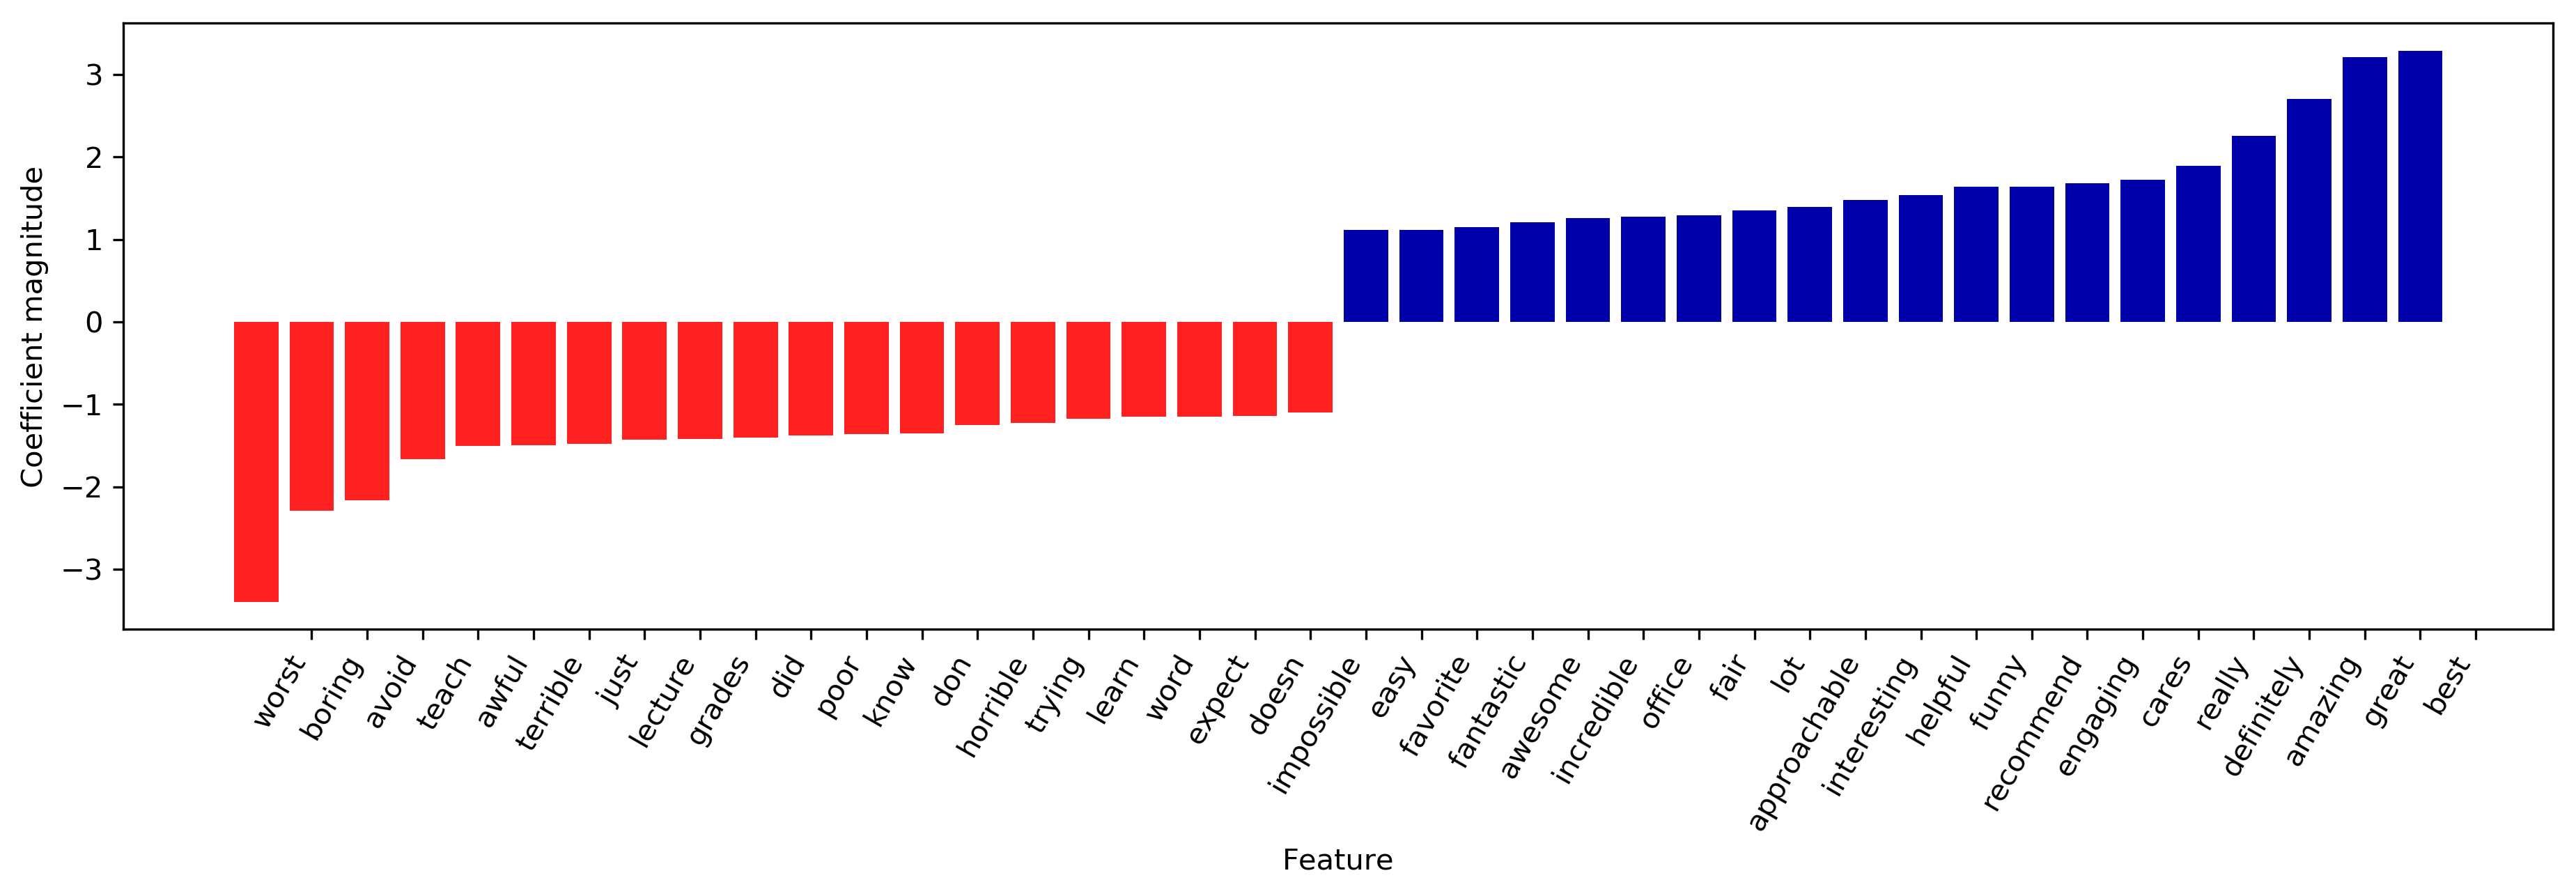

In [28]:
coefs = best_logit.named_steps["logisticregression"].coef_
features = best_logit.named_steps['tfidfvectorizer']
feature_names = np.array(features.get_feature_names())
mglearn.tools.visualize_coefficients(coefs, feature_names, n_top_features = 20)
plt.show()   

The most important features of the model are visualized above. As expected, positive adjectives such as 'best', 'great' and 'amazing' are associated with positive reviews; negative adjectives such as 'worst', 'boring' and 'avoid' are associated with non-positive reviews. While this might be obvious to a human reader, the logistic regression was able to learn these weights using only the tf-idf features in the input.

## 6. Other Models Explored <a name="6"></a>


### Logistic Regression with Count Vectorization

Count vectorization is a simple frequency matrix transformation of the input text without any weights. The frequency matrix is then used as the input for a logistic regression model.

In [40]:
vect_count = CountVectorizer(stop_words='english').fit(X_train) #, ngram_range = (1, 1), min_df = 0.005
X_train_2 = vect_count.transform(X_train)
X_test_2 = vect_count.transform(X_test)

In [31]:
scores = cross_val_score(LogisticRegression(class_weight='balanced'), X_train_2, y_train, scoring='roc_auc', cv = cv ) 
print("Mean cross-validation AUC Score: {:.2f}".format(np.mean(scores))) 

Mean cross-validation AUC Score: 0.87


In [116]:
pipe_lr_count = make_pipeline(CountVectorizer(stop_words='english'), LogisticRegression(class_weight='balanced'))
param_grid = [{'logisticregression__C':np.logspace(-3, 0, 13)}, 
              {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2), (2,3), (3,3)]},
             {'countvectorizer__min_df': np.arange(0.005, 0.055, 0.005)}] 
lr_grid_count = GridSearchCV(pipe_lr_count, param_grid, scoring='roc_auc', cv = cv)
lr_grid_count.fit(X_train, y_train)
print('Best GridsearchCV Score: ', lr_grid_count.best_score_)

Best GridsearchCV Score:  0.8808198242294061


This model seems to underperform compared to the tf-idf model.

### Logistic Regression with Doc2Vec Embedding

The Doc2Vec algorithm creates a numerical representation of input documents (in this case reviews). The representation is obtained by creating a feature vector out of a Word2Vec embedding. In the following model, Doc2Vec embedding is used as an input to the logistic regression.

In [42]:
def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(line), [i])
            
train_corpus = list(read_corpus(X_train))
test_corpus = list(read_corpus(X_test, tokens_only=True))
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=55)

In [48]:
vectors = [model.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]    
X_train_3 = np.vstack(vectors)

In [49]:
test_vectors = [model.infer_vector(test_corpus[doc_id])
                for doc_id in range(len(test_corpus))]   
X_test_3 = np.vstack(test_vectors)

In [52]:
lr = LogisticRegression(class_weight='balanced').fit(X_train_3, y_train)
print('Training Accuracy: ', lr.score(X_train_3, y_train))
print('Testing Accuracy: ', lr.score(X_test_3, y_test))

Training Accuracy:  0.7688775510204081
Testing Accuracy:  0.6834862385321101


The accuracy for the doc2vec embedding turned out to be quite disappointing. However, the doc2vec embedding will come in useful for the recommendation engine attempted later.

### Random Forest with Count Vectorization

In [37]:
rf = RandomForestClassifier(class_weight='balanced', random_state= 42)
rf.fit(X_train_2, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [39]:
print('Model Accuracy: ', rf.score(X_train_2, y_train))
rf_pred = rf.predict(X_train_2)
print('Model AUC Score: ', roc_auc_score(y_train, rf_pred))

Model Accuracy:  0.9959183673469387
Model AUC Score:  0.9947846210129575


In [41]:
print('Model Accuracy: ', rf.score(X_test_2, y_test))
rf_pred = rf.predict(X_test_2)
print('Model AUC Score: ', roc_auc_score(y_test, rf_pred))

Model Accuracy:  0.7568807339449541
Model AUC Score:  0.6608019212697087


While the training accuracy/AUC score for this random forest model was initially promising, the testing results fared much worse which indicates that the model was overfitting to the data. While the model performance could probably be improved with hyperparamater tuning, the testing results are so much worse than those of logistic regression that we decided that it was not worth the effort.

### Random Forest with tf-idf Vectorization

In [33]:
rf = RandomForestClassifier(class_weight='balanced', random_state= 42)
rf.fit(X_train_1, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [35]:
print('Model Accuracy: ', rf.score(X_train_1, y_train))
rf_pred = rf.predict(X_train_1)
print('Model AUC Score: ', roc_auc_score(y_train, rf_pred))

Model Accuracy:  0.9923469387755102
Model AUC Score:  0.9912921037630703


In [36]:
print('Model Accuracy: ', rf.score(X_test_1, y_test))
rf_pred = rf.predict(X_test_1)
print('Model AUC Score: ', roc_auc_score(y_test, rf_pred))

Model Accuracy:  0.7477064220183486
Model AUC Score:  0.6845045421321917


In [34]:
scores = cross_val_score(rf, X_train_1, y_train, scoring='roc_auc', cv = cv)
print("Mean cross-validation AUC Score: {:.2f}".format(np.mean(scores))) 

Mean cross-validation AUC Score: 0.81


Even with the tf-idf matrix input, the random forest model still exhibited high model variance and fared much worse than even an untuned logistic regression.

## 7. Recommendation Engine (Abandoned Feature) <a name="7"></a>

One of the planned features for our web app was a recommendation engine in which similar professors could be matched. However, since CULPA did not provide any user data, this turned out to be a *cold start* problem and so we had to use the contents of the text reviews to make recommendations. We first transformed the text reviews into a doc2vec matrix, and then obtained the average review vector for each professor. Then from there we obtained the pairwise distance among all the professors in the dataset. The top *n* closest professors are then returned as recommendations. The following is an implementation on a subset of 2178 professors.

In [68]:
def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(
                gensim.utils.simple_preprocess(line), [i])
            
corpus = list(read_corpus(X))
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
model.build_vocab(train_corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=55)

In [75]:
vectors = [model.infer_vector(corpus[doc_id].words)
          for doc_id in range(len(corpus))]    
rv_vectors = np.vstack(vectors)

In [71]:
df_prof = df[23391:]
num_prof = len(set(df_prof.professor_name)) - 1
prof_list = list(set(df_prof.professor_name))
prof_list.pop(0)
prof_list = sorted(prof_list)

In [84]:
df_prof['vectors'] = list(rv_vectors)
avg_vec = []

for prof in prof_list:        
    avg_vec.append(np.mean(df_prof.vectors[df_prof.professor_name == prof]))

C:\Users\Nicholas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [88]:
from sklearn.metrics import pairwise_distances

prof_prof = 1 - pairwise_distances(avg_vec, metric = 'cosine')

In [90]:
def similar_profs(prof, top_n, matrix = prof_prof, prof_list = prof_list):
    
    # get index
    idx = prof_list.index(prof)
    
    # find indices of top_n similar profs
    top = np.argsort(-prof_prof[:, idx])[1 : top_n+1]
    
    # return similar professors
    similar_profs = []
    for t in top:
        similar_profs.append(prof_list[t])
        
    return similar_profs  

In [99]:
similar_profs('Blaer, Paul', 10)

['Cannon, Adam',
 'Vovsha, Ilia',
 'Gallagher, Patrick',
 'Neath, Ronald ',
 'Lewis, Yitzhak',
 'Chen, Xi',
 'Ortoleva, Pietro',
 'Woodbury, Michael',
 'Sala-i-Martin, Xavier',
 'Diogo, LuÃ\xads']

When we use Paul Blaer as an input, we get Adam Cannon, Ilia Vovsha and Patrick Gallagher as the top 3 similar professors. Blaer is from the computer science department, as are Cannon and Vovsha (Gallagher is from the closely-allied math department). But beyond the similar departments, we could not discern what exactly made these instructors similar to Blaer (or each other) or why they were worth recommending.

In [101]:
similar_profs('Hsu, Daniel', 10)

['Cunningham, John',
 'Chen, Xi',
 'Yannakakis, Mihalis',
 'Gallagher, Patrick',
 'Zeitlin, Anton',
 'Blaer, Paul',
 'Zhang, Xiangwen',
 'di Cerbo, Gabriele',
 'Friedman, Robert',
 'Barraquand, Guillaume']

Daniel Hsu is a professor of machine learning in the computer science department. John Cunningham also teaches machine learning, albeit in the statistics department, so it is reasonable for Cunningham to be a recommendation. However, Xi Chen seems to be in engineering, and Yannakakis teaches theoretical computer science. Again, the recommendations seem to have been made on the basis of similar keywords used in the reviews rather than in any deeper underlying structure of the reviews. For example, while Hsu has mostly positive reviews, Chen Xi has overwhelmingly negative reviews.

We decided that the recommendation results based on cosine similarity between the professors' average reviews were not sufficiently robust, and so abandoned this feature for our web app.

## 8. Flask Webapp and SQLite <a name="8"></a>

### Functionality
The webapp displays multiple leaderboards of top scoring professors, with the score constructed from CULPA reviews as discussed previously. Leaderboards by department can also be selected. To ensure that the leaderboards are up-to-date, only professors with recent enough reviews are considered. Only professors with a minimum threshold of reviews are considered for the leaderboards as well. An alltime leaderboard can also be viewed to see the top professors of all time.

On the homepage, professors may also be searched for to see their individual scores, including professors that are not ranked in the leaderboard. From the professor page, summarized reviews from CULPA are provided after processing above. Links may be followed to see the original review on CULPA. Information on the coureses taught by the professor, the department the professor belongs to, and the review scores are also included.

### Details

The webapp was created using Flask, under the guidance of the Flask tutorial by Miguel Grinberg. As per his recommendation, the app was set up such that it is created in the form of a Python package. All relevant scripts, HTML templates, and CSS files are structured in an easily separable layout and importing models and functions from various scripts are also easily carried out. 

The webapp consists of:
- app directory (package)
    - `__init__.py` : create package
    - `db_access.py` : transferring dataframe contents into database
    - `forms.py` : creating fillable form classes
    - `models.py` : defining database schema
    - `routes.py` : viewing functions, mapping functions to webpages
    - `tables.py` : creating tables to hold queried data
- templates directory
    - various html templates
- static directory
    - css style sheets
    

### SQL Database
Due to the relational nature of the data we worked with and display in the webapp, the decision was made to use an SQL database to store and query the scraped CULPA data. The SQL framework allowed us to easily work with many-to-many relationships between professors, courses, and departments, as professors are not bound to specific departments or courses. No explicit knowledge of SQL commands was needed as everything was done through the `Flask-SQLAlchemy` interface. Given the small nature of the webapp, the SQLite engine was chosen, with the databased housed locally. `Flask-migrate` was also used to allow easy migration of data as changes are made to the database schema, which was very useful as we had to modify the schema multiple times to accommodate new features.  

In [ ]:
# Code snippets from the various Python scripts

# --------- __init__.py in the app folder --------------
app = Flask(__name__) # initializing the app instance
db = SQLAlchemy(app) # initializing the db instance
migrate = Migrate(app, db) # configuring the migration framework


# --------- example of database table creation in models.py------------
class Professor(db.Model):
    __tablename__ = 'professors'
    pid = db.Column(db.Integer, primary_key=True)
    pname = db.Column(db.String(128))
    nuggets = db.Column(db.Integer)
    score = db.Column(db.Numeric(precision=2))
    nrev = db.Column(db.Integer)

    departments = db.relationship("Department",
                    secondary=professor_department)
    courses = db.relationship("Course",
                    secondary=professor_course)   
    reviews = db.relationship("Review", backref='professors',
                                            lazy='dynamic', cascade="delete")         

    def __repr__(self):
        return '<Professor {} with culpa_id {}'.format(self.pname, self.pid)
    
# example of defining relationship between professors and departments
professor_department = db.Table('professor_department',
    db.Column('did', db.Integer, db.ForeignKey('departments.did')),
    db.Column('pid', db.Integer, db.ForeignKey('professors.pid')))


Ideally, we would have preferred to scrape data directly into the SQL database. However, due to issues discussed before, the decision was made to scrape data into a `Pandas` dataframe, followed by having data imputed from the dataframe into the database.

In [ ]:
# Example of database impuptation from dataframe in db_access.py
def import_reviews(df):

    def insertstr(item):
        if item.isnull().bool():
            return None
        else:
            return str(item.values[0])
    
    def insertint(item):
        if item.isnull().bool():
            return None
        else:
            return int(item)

    review_ids = list(df.review_id)
    for i in tqdm(review_ids):
        series = df.loc[df.review_id==i, :]
        
        try:
            r = Review(**{
                'rid' : int(series.review_id),
                'date' : pd.to_datetime(series.review_date.values[0]),
                'text' : str(series.review_text.values[0]),
                'agree' : int(series.agree_score),
                'disagree' : int(series.disagree_score),
                'funny' : int(series.funny_score),
                'workload' : insertstr(series.workload),
                'workload_label' : insertint(series.workload_label),
                'review_label' : insertint(series.review_label),
                'pid' : insertint(series.professor_id),
                'cid' : insertint(series.course_id)
            })
            db.session.add(r)
            db.session.commit()
        except:
            db.session.rollback()
            print('error importing review {}'.format(i))

Once the database was set up and populated, the `route` decorator functions in the `Flask` package allowed relatively easy linkage of Python functions to webpages. `Flask-WTForms` and `Flask-table` were used to configure input forms and output tables. For the various leaderboards, relevant results are queried from the database and displayed.  

In [ ]:
# example of flask form
class SearchForm(FlaskForm):
    professor_name = StringField('Professor Name')
    department_select = SelectField('Department', coerce=int, validators=[Optional()])
    course_name = StringField('Course Name', validators=[Optional()])
    submit = SubmitField('Search')
    
# example of leaderboard page queries
@app.route('/leaderboard', methods=['GET', 'POST'])
def leaderboard():
    title = 'Overall Leaderboard'
    name = 'Overall'

    # chained queries
    qry = Professor.query.filter(Professor.nrev>=15).order_by(Professor.score.desc()).limit(50)
    qry = qry.from_self().filter(Professor.reviews.any(Review.date > '2016-01-01'))
    qry = qry.order_by(Professor.score.desc()).limit(20)
    items = qry.all()

    ptable = ProfessorTable(items, border=False, classes=['ltable'])

    return render_template('leaderboard.html', name=name, title=title, ptable=ptable)



## 9. Drawbacks of pythonanywhere and Future Features <a name="9"></a>

Due to the space limitation of pythonanywhere, we were forced to limit the functionality of the webapp. While the summarizer function and score predictions can be carried out in the app, as the packages necessary were not able to be installed, the decision was made to do processing on local notebooks, and their final results imputed into the database for display.

Given a proper webhosting framework, several features would ideally be implemented.
- Weekly updates to the leaderboards by automatic scraping of new data from CULPA directly into the database
    - Current database schema is flexible enough to accommodate direct imputation
- Have analysis done on the server side, with models preserved and updated using pickle and new data.
- Implement the recommendation feature on the webapp.
- Long term: incorporate reviews from Vergil
- Long term: change database engine to PostgreSQL or MySQL